# Exploratory Data Analysis and Clustering of Student Performance Data

This project explores the performance of 100 students based on their assessment marks across four tutor-marked assignments (TMAs) and four computer-marked assessments (iCMAs).

The analysis begins by engineering new features such as the mean iCMA score and an overall assessment score (OAS), which is then used to assign students into grades (*Fail, Pass, Merit, Distinction*).

Exploratory data analysis is performed to understand grade distribution, followed by clustering techniques to investigate whether students naturally form distinct groups.

Using data cleaning, dimensionality reduction (MDS), and k-means clustering, the project identifies performance clusters and compares them against grade categories.

The workflow demonstrates a full **data science pipeline**: data preprocessing, feature engineering, exploratory analysis, clustering, and insights.


In [11]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data Preprocessing and Feature Engineering

### Calculating Mean iCMA Scores  

The dataset of student marks was loaded from CSV into a Pandas DataFrame. Missing values were replaced with zeros to ensure that incomplete submissions did not inflate results. A new column was then created for each student, containing the mean of their four iCMA scores. This provides a single measure of iCMA performance that can be combined later with TMA results.  


In [3]:
# Load the data from the CSV file into a data frame
marks = pd.read_csv('class23.csv', index_col=0)
marks.fillna(0, inplace=True)

# Calculate mean value of iCMAs
icma = ['iCMA 01', 'iCMA 02','iCMA 03', 'iCMA 04']
marks['Mean iCMA'] = marks[icma].mean(axis=1)
marks

,TMA 01,TMA 02,TMA 03,TMA 04,iCMA 01,iCMA 02,iCMA 03,iCMA 04,Mean iCMA
Student ID,,,,,,,,,
MT152,0.0,75.0,65.0,70.0,70.0,69.0,76.0,0.0,53.75
EU290,0.0,0.0,93.0,93.0,0.0,99.0,77.0,0.0,44.00
VJ332,0.0,38.0,32.0,34.0,27.0,0.0,47.0,43.0,29.25
CN471,0.0,69.0,85.0,95.0,83.0,0.0,60.0,81.0,56.00
AS842,86.0,0.0,74.0,84.0,85.0,72.0,79.0,0.0,59.00
...,...,...,...,...,...,...,...,...,...
CE293,0.0,62.0,76.0,83.0,0.0,65.0,77.0,75.0,54.25
GJ067,82.0,80.0,0.0,98.0,85.0,93.0,0.0,0.0,44.50
QT829,61.0,62.0,66.0,58.0,65.0,0.0,69.0,66.0,50.00


### Calculating Overall Assessment Score (OAS)  

To create a single measure of overall performance, I combined each student’s TMA marks (TMA01–TMA04) with their mean iCMA score.  
For consistency, the top four values across these assessments were selected for each student, and their mean was calculated.  
This new feature was added to the dataset as the **Overall Assessment Score (OAS)**, which serves as the basis for assigning grades.  


In [4]:
# Components of OAS are sorted and mean is calculated for top four values
OAS_comp = ['TMA 01', 'TMA 02','TMA 03', 'TMA 04', 'Mean iCMA']
OAS_comp_sorted = marks[OAS_comp].apply(sorted, axis=1, result_type='expand')
top_four = OAS_comp_sorted.iloc[:, 1:5]
#print (top_four)
marks['OAS'] = top_four.mean(axis=1)
marks

,TMA 01,TMA 02,TMA 03,TMA 04,iCMA 01,iCMA 02,iCMA 03,iCMA 04,Mean iCMA,OAS
Student ID,,,,,,,,,,
MT152,0.0,75.0,65.0,70.0,70.0,69.0,76.0,0.0,53.75,65.9375
EU290,0.0,0.0,93.0,93.0,0.0,99.0,77.0,0.0,44.00,57.5000
VJ332,0.0,38.0,32.0,34.0,27.0,0.0,47.0,43.0,29.25,33.3125
CN471,0.0,69.0,85.0,95.0,83.0,0.0,60.0,81.0,56.00,76.2500
AS842,86.0,0.0,74.0,84.0,85.0,72.0,79.0,0.0,59.00,75.7500
...,...,...,...,...,...,...,...,...,...,...
CE293,0.0,62.0,76.0,83.0,0.0,65.0,77.0,75.0,54.25,68.8125
GJ067,82.0,80.0,0.0,98.0,85.0,93.0,0.0,0.0,44.50,76.1250
QT829,61.0,62.0,66.0,58.0,65.0,0.0,69.0,66.0,50.00,61.7500


### Assigning Grades and Visualising Distribution  

Based on the Overall Assessment Score (OAS), each student was assigned a grade of *Fail, Pass, Merit,* or *Distinction* according to the defined thresholds.

These grades were added as a new column in the dataset, making performance categories explicit.


| Grade | Condition for grade |
 |--|---|
 |   Fail | $0\leq\text{OAS} < 40$ |
 |   Pass | $40\leq\text{OAS} < 60$ |
 |   Merit | $60\leq\text{OAS} < 75$ |
 |   Distinction | $75\leq\text{OAS} \leq 100$ |

In [5]:
# Condition is introduced
thresholds = np.array([0, 40, 60, 75, 101])

# Score- numerical value classifies each grade
marks['Score'] = 5-np.searchsorted(thresholds, marks['OAS'], side='right')

#Each score is substituted with their Grade
grade_map = {4: 'Fail', 3: 'Pass', 2: 'Merit', 1: 'Distinction'}
marks['Grade'] = marks['Score'].map(grade_map)
marks

,TMA 01,TMA 02,TMA 03,TMA 04,iCMA 01,iCMA 02,iCMA 03,iCMA 04,Mean iCMA,OAS,Score,Grade
Student ID,,,,,,,,,,,,
MT152,0.0,75.0,65.0,70.0,70.0,69.0,76.0,0.0,53.75,65.9375,2,Merit
EU290,0.0,0.0,93.0,93.0,0.0,99.0,77.0,0.0,44.00,57.5000,3,Pass
VJ332,0.0,38.0,32.0,34.0,27.0,0.0,47.0,43.0,29.25,33.3125,4,Fail
CN471,0.0,69.0,85.0,95.0,83.0,0.0,60.0,81.0,56.00,76.2500,1,Distinction
AS842,86.0,0.0,74.0,84.0,85.0,72.0,79.0,0.0,59.00,75.7500,1,Distinction
...,...,...,...,...,...,...,...,...,...,...,...,...
CE293,0.0,62.0,76.0,83.0,0.0,65.0,77.0,75.0,54.25,68.8125,2,Merit
GJ067,82.0,80.0,0.0,98.0,85.0,93.0,0.0,0.0,44.50,76.1250,1,Distinction
QT829,61.0,62.0,66.0,58.0,65.0,0.0,69.0,66.0,50.00,61.7500,2,Merit


## Exploratory Data Analysis (EDA)

### Visualising Distribution
To better understand the distribution of outcomes across the class, I plotted a bar chart showing the number of students in each grade group.

The results reveal a fairly balanced spread, with the largest group achieving a *Pass* and smaller but significant numbers in the other categories.

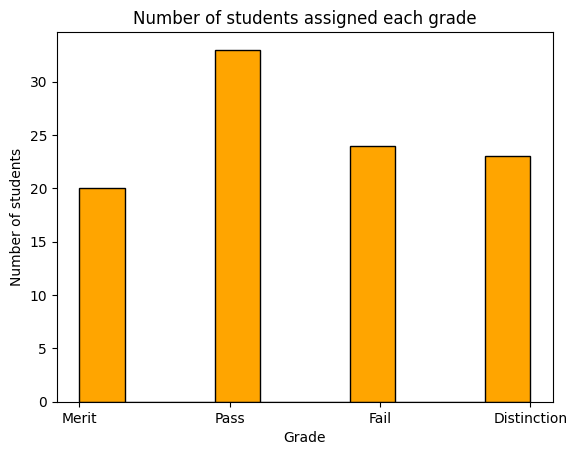

,Number of students
Grade,
Distinction,23
Fail,24
Merit,20
Pass,33


In [6]:
# Bar Chart for the number of students assigned each grade
plt.hist(marks['Grade'], edgecolor='black', color='orange', histtype='bar')
plt.xlabel('Grade')
plt.ylabel('Number of students')
plt.title('Number of students assigned each grade')
plt.show()

# Summary table showing the number of students with each grade
summary = marks.pivot_table(index='Grade', columns=[], values='Score', aggfunc=len)
summary = summary.rename(columns={'Score': 'Number of students'})
summary

## Clustering Analysis

### Data Cleaning for Clustering  

Before applying clustering methods, the dataset was cleaned to handle missing values. For each student, any missing TMA or iCMA scores were replaced with the mean of their remaining assessment scores.

This approach preserves overall performance patterns without introducing bias from zeros or dropping records. The cleaned dataset forms the basis for the dimensionality reduction and clustering steps that follow.  


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from the CSV file into a data frame
marks2 = pd.read_csv('class23.csv', index_col=0)
A = ['iCMA 01', 'iCMA 02','iCMA 03', 'iCMA 04','TMA 01', 'TMA 02','TMA 03', 'TMA 04']
marks2['Mean A'] = marks2[A].mean(axis=1, skipna=True)

# NaN values filled with the corresponding 'Mean A' value and looped through each row
for index, row in marks2.iterrows():
    marks2.loc[index, 'TMA 01':'iCMA 04'] = row['TMA 01':'iCMA 04'].fillna(row['Mean A'])

marks2 = marks2.drop(columns='Mean A')

marks2

,TMA 01,TMA 02,TMA 03,TMA 04,iCMA 01,iCMA 02,iCMA 03,iCMA 04
Student ID,,,,,,,,
MT152,70.833333,75.0,65.0,70.0,70.0,69.000000,76.0,70.833333
EU290,90.500000,90.5,93.0,93.0,90.5,99.000000,77.0,90.500000
VJ332,36.833333,38.0,32.0,34.0,27.0,36.833333,47.0,43.000000
CN471,78.833333,69.0,85.0,95.0,83.0,78.833333,60.0,81.000000
AS842,86.000000,80.0,74.0,84.0,85.0,72.000000,79.0,80.000000
...,...,...,...,...,...,...,...,...
CE293,73.000000,62.0,76.0,83.0,73.0,65.000000,77.0,75.000000
GJ067,82.000000,80.0,87.6,98.0,85.0,93.000000,87.6,87.600000
QT829,61.000000,62.0,66.0,58.0,65.0,63.857143,69.0,66.000000


### Clustering with MDS and k-Means  

To explore whether the students naturally form distinct groups, I first reduced the dataset to two dimensions using **Multidimensional Scaling (MDS)** on the cleaned marks data. The reduced representation was then clustered using **k-means with k=2**.  

The resulting scatterplot shows a clear separation between two groups of students, supporting the idea that performance divides into two distinct clusters.


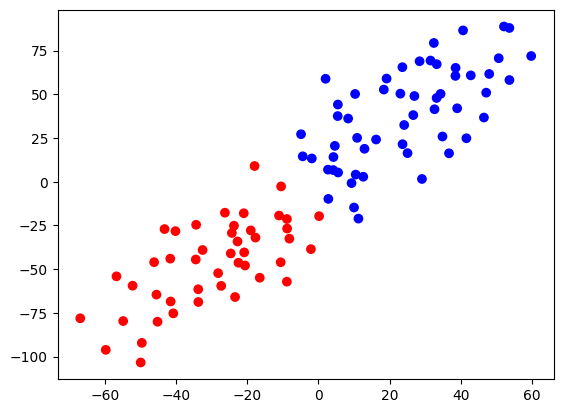

In [9]:
# Relevant code imported
from scipy.cluster.vq import kmeans2
from scipy.cluster.vq import whiten as sphere
from scipy.spatial.distance import cdist
from sklearn.manifold import MDS

# Distances calculated between points in the marks dataset
D = cdist(marks2, marks2)

# Performed MDS to calculate two-dimensional representation of the
# dataset based on the distance matrix D, with k = 2
X = MDS(n_components=2, dissimilarity='precomputed').fit_transform(D)
centres, classification = kmeans2(sphere(X), 2)
colours = np.array(['r', 'b'])
colour_labels = colours[classification]
plt.scatter(X[:, 0], X[:, 1], color=colour_labels);

## Insights


### Cluster Insights with Pivot Tables  

To better understand the clustering results, I created a pivot table comparing grade distribution across the two clusters.

- The table shows that one cluster mostly consists of higher-performing students, with the majority achieving *Merit* or *Distinction*.  

- In contrast, the other cluster is dominated by lower-performing students, primarily in the *Pass* and *Fail* categories.

A few mismatches appear (e.g., fails within the cluster with higher-performing students), which may represent outliers.

In [10]:
# Label and separate data of each cluster
marks2['Cluster'] = classification
cluster0 = marks2[marks2['Cluster'] == 0]
cluster1 = marks2[marks2['Cluster'] == 1]
merged_marks = pd.merge(marks , marks2['Cluster'], on='Student ID', how='left')

# Creating a pivot table
pivot_table = pd.pivot_table(merged_marks, values=marks.columns[0], index='Cluster'\
                             , columns='Grade', aggfunc='count')

# Formatting the table for improved clarity
pivot_table = pivot_table[['Distinction', 'Merit', 'Pass', 'Fail']]
pivot_table = pivot_table.fillna(0)

pivot_table

Grade,Distinction,Merit,Pass,Fail
Cluster,,,,
0,0.0,0.0,23.0,22.0
1,23.0,20.0,10.0,2.0


## Conclusion  

This analysis of student assessment data demonstrates how feature engineering, exploratory analysis, and unsupervised learning can be combined to extract meaningful insights.
By computing overall scores and assigning grades, the dataset was made interpretable in terms of performance categories.  
Clustering with MDS and k-means revealed two distinct groups of students that largely align with grade outcomes, while also highlighting interesting outliers such as strong students with missing work or weaker students performing above expectation.